<a href="https://colab.research.google.com/github/A-keerthana/Google-Stock-Price-Prediction-using-LSTM/blob/main/Google_Stock_Price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Styling notebook
from IPython.core.display import HTML
css_file= """
<style>
div.input_area {
    background-color: #F1F0F0; /* gray */
    border-top: 2px solid #000000; /* black */
}

@import url('https://fonts.googleapis.com/css?family=Quicksand&display=swap');
 * {
    margin: 0;
    padding: 0;
    box-sizing: border-box;
}

 .alert {
    width: 80%;
    margin: 20px auto;
    padding: 30px;
    position: relative;
    border-radius: 5px;
    box-shadow: 0 0 15px 5px #ccc;
}
 .close {
    position: absolute;
    width: 30px;
    height: 30px;
    opacity: 0.5;
    border-width: 1px;
    border-style: solid;
    border-radius: 50%;
    right: 15px;
    top: 25px;
    text-align: center;
    font-size: 1.6em;
    cursor: pointer;
}
 .simple-alert {
    background-color: #aed6e5;
    border-left: 5px solid #245b70;
}
 .simple-alert .close {
    border-color: #245b70;
    color: #245b70;
}
 .success-alert {
    background-color: #aee5c0;
    border-left: 5px solid #24703d;
}
 .success-alert .close {
    border-color: #24703d;
    color: #24703d;
}
 .danger-alert {
    background-color: #e5aeae;
    border-left: 5px solid #702424;
}
 .danger-alert .close {
    border-color: #702424;
    color: #702424;
}
 .warning-alert {
    background-color: #ffe6a9;
    border-left: 5px solid #a97800;
}
 .warning-alert .close {
    border-color: #a97800;
    color: #a97800;
}

li {
  list-style: none; /* Remove default bullets */
}

ul li::before {
  content: "•";
  color: #B41B10;
  font-weight: bold;
  display: inline-block; /* Needed to add space between the bullet and the text */
  width: 1em; /* Also needed for space (tweak if needed) */
  margin-left: -1em; /* Also needed for space (tweak if needed) */
  font-size:120%;
}

.number{
    color:#B41B10;
}

mark {
 background-color:#D59A99;
 color:#B41B10;
 border-radius: 6px;
 padding: 2px 5px;
}

.btn {
  background-color: gray;
  border: none;
  color: white !important;
  padding: 5px 15px;
    font-size: 18px;
  cursor: pointer;
}

/* Darker background on mouse-over */
.btn:hover {
  background-color: Red;
}

</style>
"""
HTML(css_file)

In [2]:
# install some requirement libraries
!pip install torch-summary
!pip install yfinance

In [3]:
# import requirement libraries and tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import yfinance as yf
import torch.nn as nn
import torch.functional as F
import plotly.graph_objects as go

from tqdm.notebook import tqdm
from torchsummary import summary
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

In [4]:
# create a ticker object for Google (GOOGL)
ticker = yf.Ticker("GOOG")

# Define the start and end dates
start_date = "2016-06-14"

# Get historical data for the specified date range
df = ticker.history(start=start_date, end=None)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-06-14 00:00:00-04:00,35.824001,36.123501,35.655998,35.913502,26122000,0.0,0.0
2016-06-15 00:00:00-04:00,35.950001,36.148998,35.865501,35.945999,24290000,0.0,0.0
2016-06-16 00:00:00-04:00,35.745499,35.832500,35.162998,35.518002,39650000,0.0,0.0
2016-06-17 00:00:00-04:00,35.432499,35.441002,34.422600,34.585999,68048000,0.0,0.0
2016-06-20 00:00:00-04:00,34.938499,35.124001,34.670502,34.685501,41650000,0.0,0.0


In [5]:
# Create a trace for the candlestick chart
candlestick_trace = go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    name='Candlestick'
)

# Create the layout
layout = go.Layout(
    title='GOOG Candlestick Chart',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price', rangemode='normal')
)

# Create the figure and add the candlestick trace and layout
fig = go.Figure(data=[candlestick_trace], layout=layout)

# Update the layout of the figure
fig.update_layout(xaxis_rangeslider_visible=False)

# Show the figure
fig.show()

In [6]:
# Move column 'Close' to the first position
col_close = df.pop('Close')
df.insert(0, 'Close', col_close)
df.head()

,Close,Open,High,Low,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-06-14 00:00:00-04:00,35.913502,35.824001,36.123501,35.655998,26122000,0.0,0.0
2016-06-15 00:00:00-04:00,35.945999,35.950001,36.148998,35.865501,24290000,0.0,0.0
2016-06-16 00:00:00-04:00,35.518002,35.745499,35.832500,35.162998,39650000,0.0,0.0
2016-06-17 00:00:00-04:00,34.585999,35.432499,35.441002,34.422600,68048000,0.0,0.0
2016-06-20 00:00:00-04:00,34.685501,34.938499,35.124001,34.670502,41650000,0.0,0.0


In [7]:
df.tail()

,Close,Open,High,Low,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-09-01 00:00:00-04:00,136.800003,138.429993,138.580002,135.940002,16665700,0.0,0.0
2023-09-05 00:00:00-04:00,136.710007,136.440002,137.369995,135.559998,17730200,0.0,0.0
2023-09-06 00:00:00-04:00,135.369995,137.014999,137.479996,134.690002,15814300,0.0,0.0
2023-09-07 00:00:00-04:00,136.199997,134.600006,136.580002,133.960007,16976000,0.0,0.0
2023-09-08 00:00:00-04:00,137.199997,135.869995,137.514999,135.869995,17810700,0.0,0.0


In [8]:
df.shape

(1822, 7)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1822 entries, 2016-06-14 00:00:00-04:00 to 2023-09-08 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Close         1822 non-null   float64
 1   Open          1822 non-null   float64
 2   High          1822 non-null   float64
 3   Low           1822 non-null   float64
 4   Volume        1822 non-null   int64  
 5   Dividends     1822 non-null   float64
 6   Stock Splits  1822 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 113.9 KB


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,1822.0,7.929146e+01,3.336747e+01,3.341300e+01,5.284263e+01,6.592825e+01,1.068524e+02,1.507090e+02
Open,1822.0,7.923709e+01,3.336612e+01,3.355000e+01,5.286238e+01,6.566850e+01,1.065913e+02,1.518635e+02
High,1822.0,8.011239e+01,3.378109e+01,3.361500e+01,5.350825e+01,6.638400e+01,1.082312e+02,1.521000e+02
Low,1822.0,7.843827e+01,3.297579e+01,3.316420e+01,5.230600e+01,6.525475e+01,1.053975e+02,1.498875e+02
Volume,1822.0,3.045928e+07,1.336464e+07,6.936000e+06,2.194150e+07,2.689300e+07,3.427700e+07,1.241400e+08
Dividends,1822.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Stock Splits,1822.0,1.097695e-02,4.685499e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+01


In [11]:
df.isna().sum().to_frame(name='num_of_NaN')

,num_of_NaN
Close,0
Open,0
High,0
Low,0
Volume,0
Dividends,0
Stock Splits,0


In [12]:
df.duplicated().sum()

0

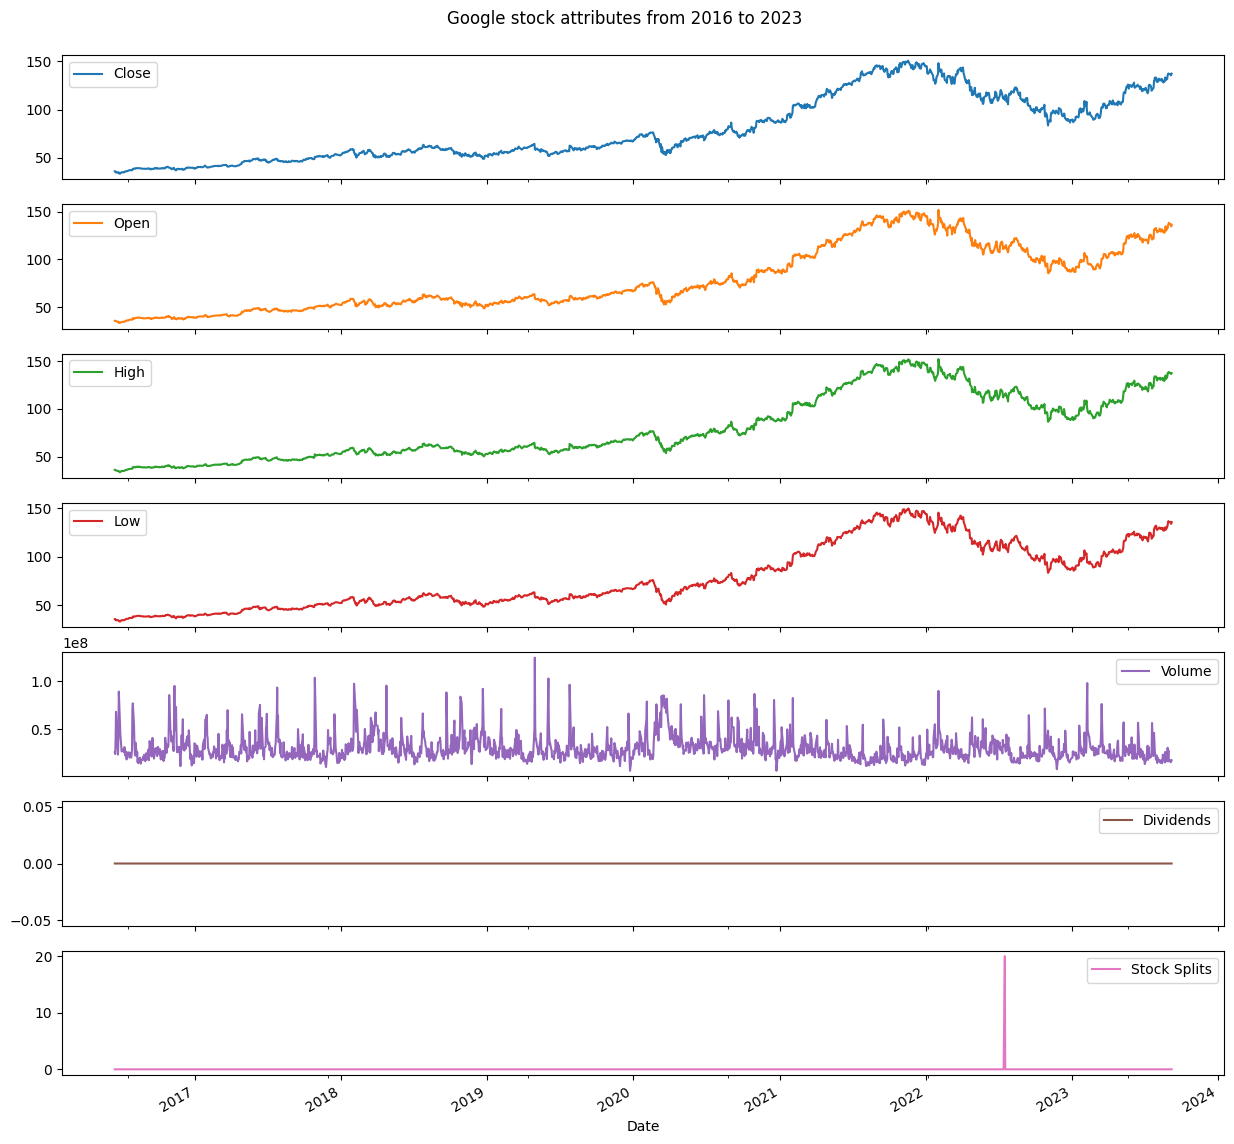

In [17]:
df.plot(subplots=True, figsize=(15, 15))
plt.suptitle('Google stock attributes from 2016 to 2023', y=0.91)
plt.show()

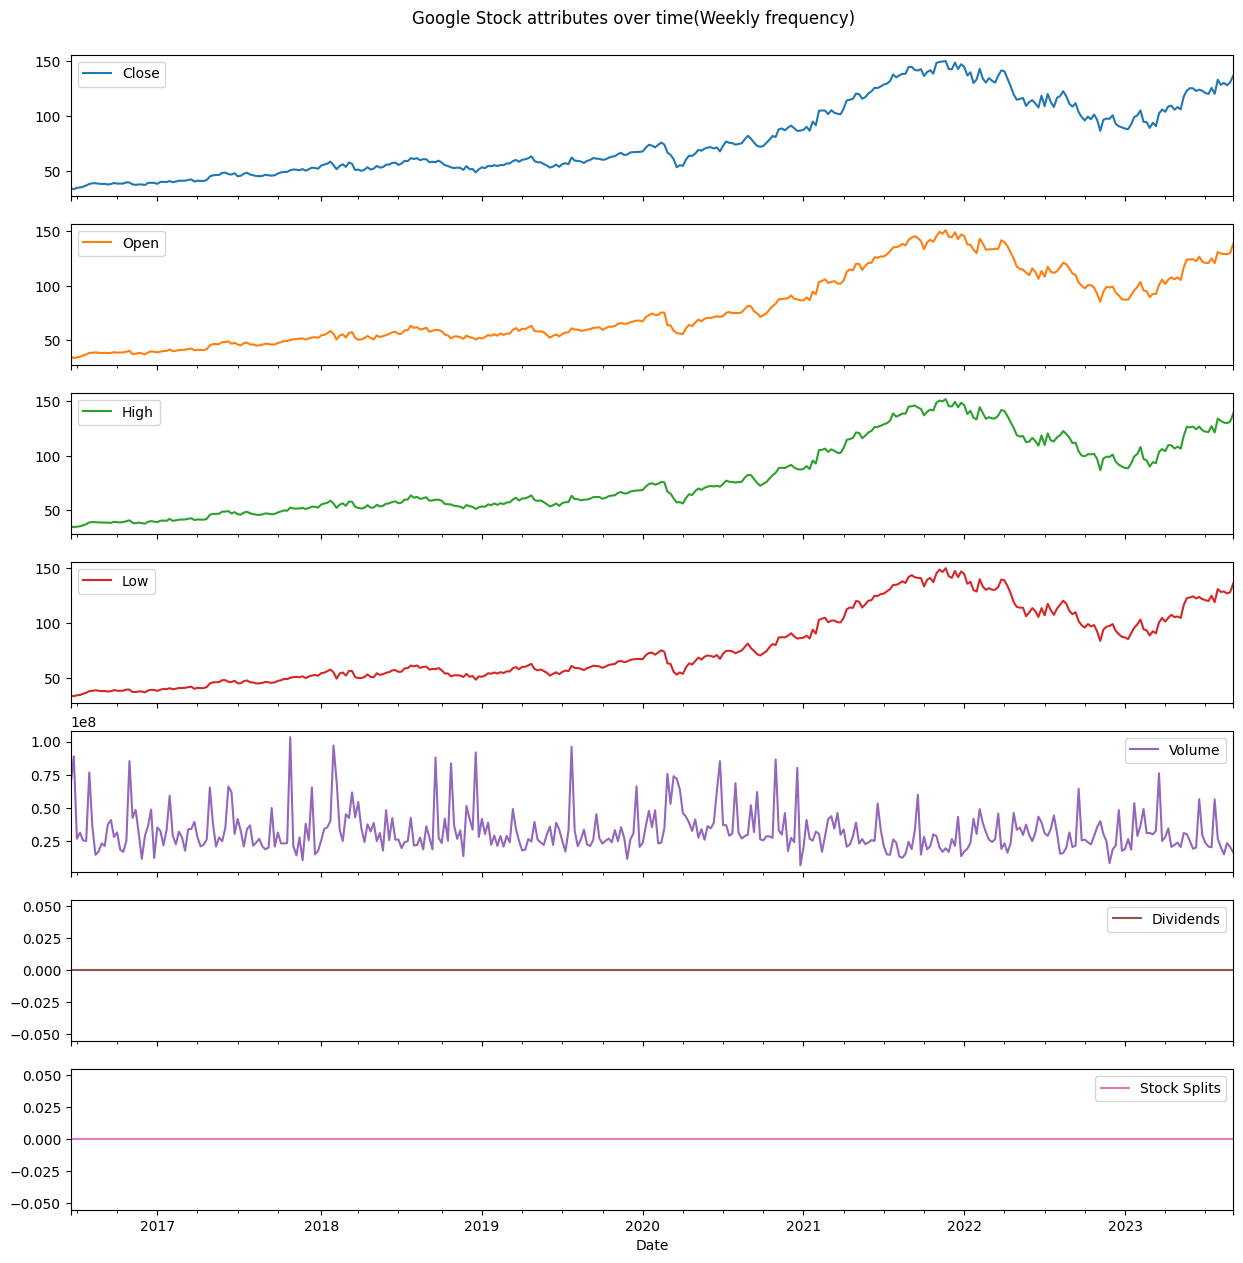

In [14]:
df.asfreq('W', method='ffill').plot(subplots=True, figsize=(15,15), style='-')
plt.suptitle('Google Stock attributes over time(Weekly frequency)', y=0.91)
plt.show()

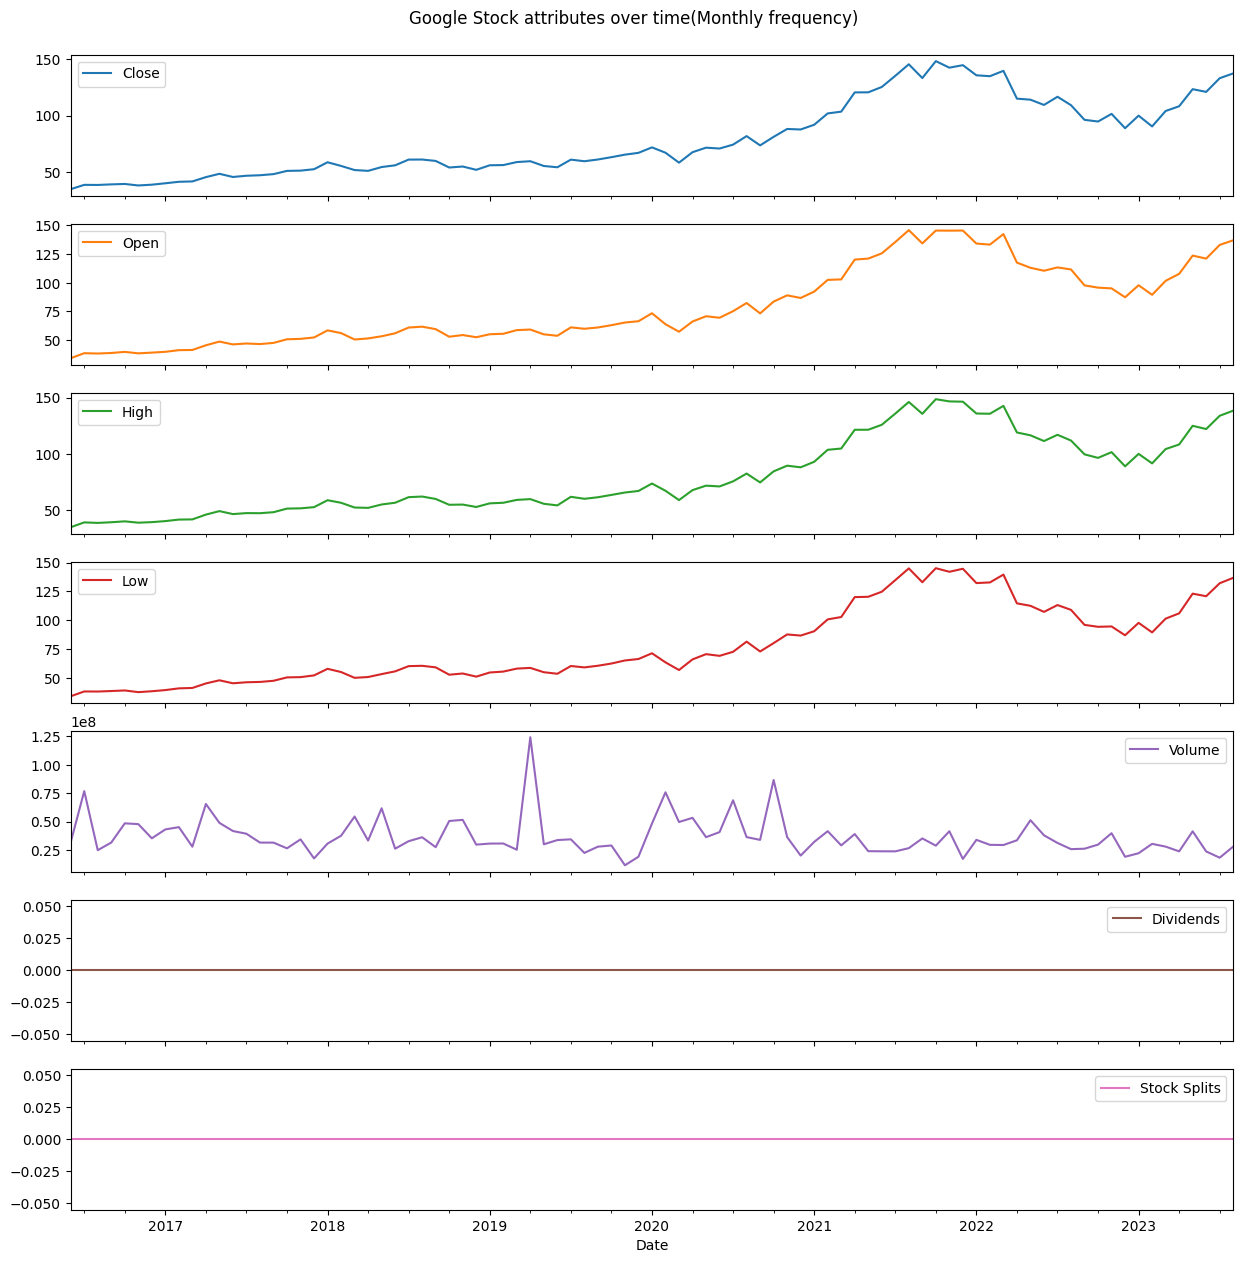

In [18]:
df.asfreq('M', method='ffill').plot(subplots=True, figsize=(15,15), style='-')
plt.suptitle('Google Stock attributes over time(Monthly frequency)', y=0.91)
plt.show()

In [19]:
df[['Close']]

,Close
Date,
2016-06-14 00:00:00-04:00,35.913502
2016-06-15 00:00:00-04:00,35.945999
2016-06-16 00:00:00-04:00,35.518002
2016-06-17 00:00:00-04:00,34.585999
2016-06-20 00:00:00-04:00,34.685501
...,...
2023-09-01 00:00:00-04:00,136.800003
2023-09-05 00:00:00-04:00,136.710007
2023-09-06 00:00:00-04:00,135.369995


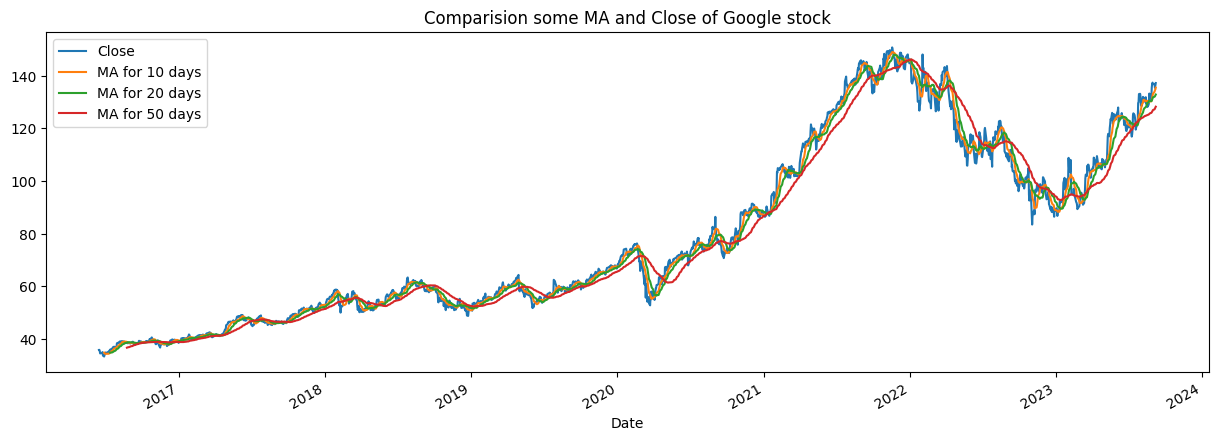

In [20]:
# computing moving average(ma)
ma_day = [10, 20, 50]

for ma in ma_day:
    col_name = f'MA for {ma} days'
    df[col_name] = df['Close'].rolling(ma).mean()

df[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(figsize=(15,5))
plt.title('Comparision some MA and Close of Google stock')
plt.show()


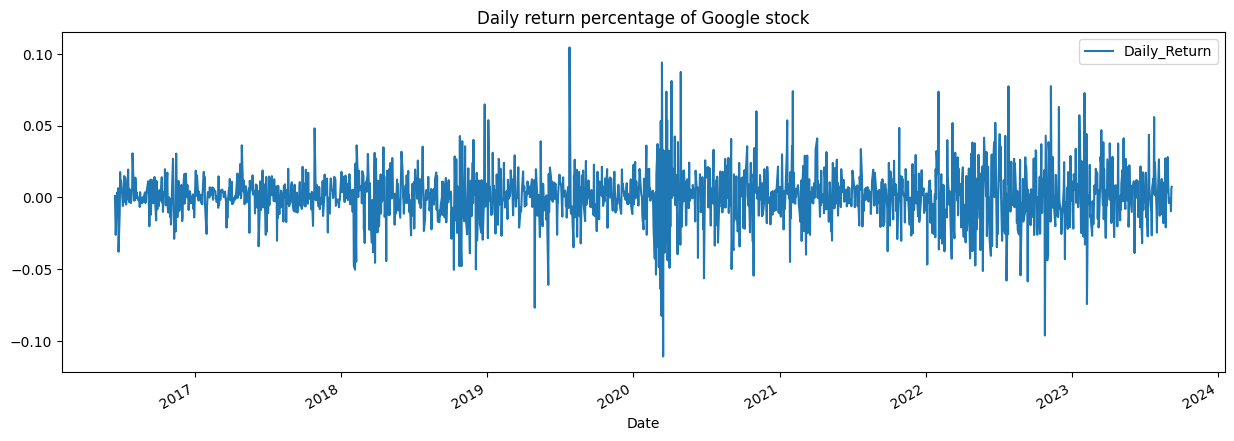

In [21]:
# use pct_change to find the percent change for each day
df['Daily_Return'] = df['Close'].pct_change()
# plot the daily return percentage
df.Daily_Return.plot(legend=True, figsize=(15,5))
plt.title('Daily return percentage of Google stock')
plt.show()

In [22]:
# normalize data
df2 = df.copy(deep=True)
scaler = MinMaxScaler(feature_range=(0,15)).fit(df2.Low.values.reshape(-1,1))
df2['Open'] = scaler.transform(df2.Open.values.reshape(-1,1))
df2['High'] = scaler.transform(df2.High.values.reshape(-1,1))
df2['Low'] = scaler.transform(df2.Low.values.reshape(-1,1))
df2['Close'] = scaler.transform(df2.Close.values.reshape(-1,1))
data = df2[['Open','High','Low', 'Close']].values
data.shape

(1822, 4)

In [23]:
data

array([[ 0.34180856,  0.38029696,  0.32021864,  0.35331018],
       [ 0.35800063,  0.38357361,  0.3471417 ,  0.35748639],
       [ 0.33172026,  0.34290078,  0.25686368,  0.30248482],
       ...,
       [13.34576757, 13.40552381, 13.04698442, 13.13436963],
       [13.03541908, 13.28986645, 12.95317336, 13.24103238],
       [13.19862416, 13.4100221 , 13.19862416, 13.36954143]])

In [24]:
seq_len=11
sequences=[]
for index in range(len(data) - seq_len + 1):
    sequences.append(data[index: index + seq_len])
sequences= np.array(sequences)

In [25]:
valid_set_size_percentage = 10
test_set_size_percentage = 10

valid_set_size = int(np.round(valid_set_size_percentage/100*sequences.shape[0]))
test_set_size  = int(np.round(test_set_size_percentage/100*sequences.shape[0]))
train_set_size = sequences.shape[0] - (valid_set_size + test_set_size)

x_train = sequences[:train_set_size,:-1,:]
y_train = sequences[:train_set_size,-1,:]

x_valid = sequences[train_set_size:train_set_size+valid_set_size,:-1,:]
y_valid = sequences[train_set_size:train_set_size+valid_set_size,-1,:]

x_test = sequences[train_set_size+valid_set_size:,:-1,:]
y_test = sequences[train_set_size+valid_set_size:,-1,:]

In [26]:
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

x_valid = torch.tensor(x_valid).float()
y_valid = torch.tensor(y_valid).float()

train_dataset = TensorDataset(x_train,y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

valid_dataset = TensorDataset(x_valid,y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)


In [27]:
from torch import nn
class NeuralNetwork(nn.Module):
    def __init__(self, num_feature):
        super(NeuralNetwork, self).__init__()
        self.lstm  = nn.LSTM(num_feature,64,batch_first=True)
        self.fc    = nn.Linear(64,num_feature)

    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        x = self.fc(hidden)
        return x

model = NeuralNetwork(4)

#push to cuda if available
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

In [28]:
# print summary of model like summary in tensorflow
summary(model, (4, ))

Layer (type:depth-idx)                   Output Shape              Param #
├─LSTM: 1-1                              [-1, 64]                  17,920
├─Linear: 1-2                            [-1, 4]                   260
Total params: 18,180
Trainable params: 18,180
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07


Layer (type:depth-idx)                   Output Shape              Param #
├─LSTM: 1-1                              [-1, 64]                  17,920
├─Linear: 1-2                            [-1, 4]                   260
Total params: 18,180
Trainable params: 18,180
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07

In [29]:
optimizer = optim.Adam(model.parameters())
mse = nn.MSELoss()

In [30]:
def train(dataloader):
    epoch_loss = 0
    model.train()

    for batch in dataloader:
        optimizer.zero_grad()
        x,y= batch
        pred = model(x)
        loss = mse(pred[0],y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss

In [31]:
def evaluate(dataloader):
    epoch_loss = 0
    model.eval()

    with torch.no_grad():
      for batch in dataloader:
          x,y= batch
          pred = model(x)
          loss = mse(pred[0],y)
          epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [32]:
n_epochs = 50
best_valid_loss = float('inf')

for epoch in range(1, n_epochs + 1):

    train_loss = train(train_dataloader)
    valid_loss = evaluate(valid_dataloader)

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, 'saved_weights.pt')

    # print("Epoch ",epoch+1)
    print(f'\tTrain Loss: {train_loss:.5f} | ' + f'\tVal Loss: {valid_loss:.5f}\n')

	Train Loss: 935.40006 | 	Val Loss: 29.69570

	Train Loss: 815.36912 | 	Val Loss: 23.46863

	Train Loss: 525.38957 | 	Val Loss: 14.58780

	Train Loss: 328.90267 | 	Val Loss: 7.40973

	Train Loss: 223.89936 | 	Val Loss: 3.95285

	Train Loss: 156.33202 | 	Val Loss: 2.27105

	Train Loss: 108.37244 | 	Val Loss: 1.94034

	Train Loss: 75.71764 | 	Val Loss: 1.97804

	Train Loss: 60.90617 | 	Val Loss: 0.75083

	Train Loss: 36.99449 | 	Val Loss: 1.98387

	Train Loss: 35.34161 | 	Val Loss: 3.40851

	Train Loss: 23.17587 | 	Val Loss: 0.93850

	Train Loss: 16.14146 | 	Val Loss: 0.92036

	Train Loss: 11.73866 | 	Val Loss: 0.37519

	Train Loss: 10.88319 | 	Val Loss: 0.77751

	Train Loss: 11.37119 | 	Val Loss: 0.25017

	Train Loss: 6.95942 | 	Val Loss: 0.93351

	Train Loss: 9.77700 | 	Val Loss: 0.35564

	Train Loss: 17.74578 | 	Val Loss: 1.10945

	Train Loss: 9.52365 | 	Val Loss: 2.04096

	Train Loss: 9.92075 | 	Val Loss: 0.72120

	Train Loss: 19.70503 | 	Val Loss: 3.06520

	Train Loss: 6.37762 | 	Va

In [33]:
model=torch.load('saved_weights.pt')

In [34]:
x_test= torch.tensor(x_test).float()

with torch.no_grad():
  y_test_pred = model(x_test)

y_test_pred = y_test_pred.numpy()[0]

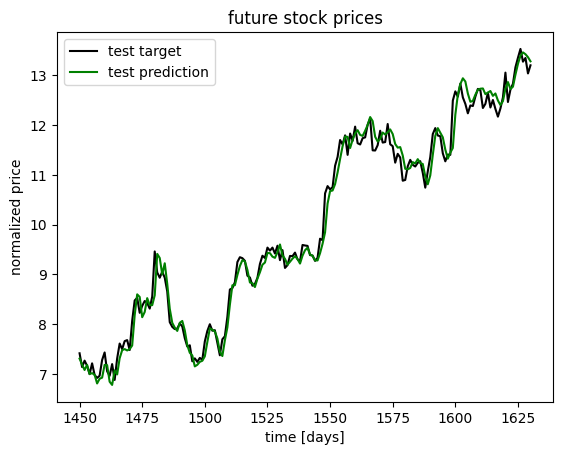

In [35]:
idx=0
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,idx], color='black', label='test target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,idx], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best')

In [36]:
index_values = df[len(df) - len(y_test):].index
col_values = ['Open', 'Low', 'High', 'Close']
df_results = pd.DataFrame(data=y_test_pred, index=index_values, columns=col_values)

In [37]:
# Create a trace for the candlestick chart
candlestick_trace = go.Candlestick(
    x=df_results.index,
    open=df_results['Open'],
    high=df_results['High'],
    low=df_results['Low'],
    close=df_results['Close'],
    name='Candlestick'
)

# Create the layout
layout = go.Layout(
    title='GOOG Candlestick Chart',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price', rangemode='normal')
)

# Create the figure and add the candlestick trace and layout
fig = go.Figure(data=[candlestick_trace], layout=layout)

# Update the layout of the figure
fig.update_layout(xaxis_rangeslider_visible=False)

# Show the figure
fig.show()

In [38]:
# Get the last sequence of historical data as features for predicting the next 10 days
last_sequence = sequences[-1:, 1:, :]
last_sequence = torch.from_numpy(last_sequence).float()

# Generate predictions for the next 10 days
PRED_DAYS = 10
with torch.no_grad():
    for i in range(PRED_DAYS):
        pred_i = model(last_sequence)
        last_sequence = torch.cat((last_sequence, pred_i), dim=1)
        last_sequence = last_sequence[:, 1:, :]


pred_days = last_sequence.reshape(PRED_DAYS, 4).numpy()

# inverse transform the predicted values
pred_days = scaler.inverse_transform(pred_days)

df_pred = pd.DataFrame(
    data=pred_days,
    columns=['Open', 'High', 'Low', 'Close']
)

df_pred

,Open,High,Low,Close
0,136.796738,138.557266,135.448807,137.102066
1,137.228394,138.976440,135.909836,137.534439
2,137.637131,139.367737,136.333405,137.943466
3,138.013748,139.726776,136.718643,138.322754
4,138.353119,140.049164,137.062576,138.666092
5,138.654373,140.334442,137.365509,138.971985
6,138.919525,140.584946,137.630386,139.241867
7,139.152588,140.804718,137.862061,139.479385
8,139.358856,140.999237,138.067429,139.689209
9,139.540741,141.170578,138.248428,139.874023
